# Game of Thrones word embeddings

I was hoping to get more out of this to be honest, but it was a good primer for working with embeddings and how to actually do it. This is really barely scratching the surface, however. I really didn't learn that much about the word vectors themselves. In the future, I'll likely stay away from "LIVE" youtube videos, as I'm sure his pre-recorded videos are much better.

It was interesting trying to debug the issue he had since he was using an older version of the **gensim** package. That helped my troubleshooting skills a bit, but that's not what I was here for.

Next I think I'd like to tackle a tutorial that does more of a deepdive on the **gensim** package so I can actually learn how to use word embeddings (I don't necessarily need to know everything about them, just how to use them).

In [1]:
# tut: https://www.youtube.com/watch?v=pY9EwZ02sXU
# books: http://persischempaka.blogspot.com/2012/04/game-of-thronestxt.html
# this tutorial kind of dead-ended...

# load important dependencies
# forward / backward compatability 
from __future__ import absolute_import, division, print_function

# for word encoding:
import codecs

#regex?
import glob

#concurrency
import multiprocessing

# dealing with os like reading in a file
import os

# pretty printing, human readable:
import pprint

# regular expressions - regex
import re

# natural language toolkit
import nltk

#word 2 vec word embeddings (WE ARE TRAINING THESE)
import gensim.models.word2vec as w2v


# dimsneionality reduction (SO EXCITING!)
import sklearn.manifold

# math
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# parse pandas as pd
import pandas as pd

# visualization
import seaborn as sns


C:\venv\py2764\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Step1 process our data (clean data)

# downloads pre-trained tokenizer
nltk.download('punkt')     

# common words we don't care about (articles like "and" and "the")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Taylor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Taylor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# get the book names, matching txt file

"""
NOTE: I removed books 4 and 5 because those text files had
some type of error with utf-8 encoding, I care much more
about learning word embedding strategies than trouble-
shooting encoding issues, we will power through!

"No fear. No distractions. The ability to let that which 
does not matter, truly slide."
"""

book_filenames = sorted(glob.glob('*.txt'))
print(book_filenames)

['001ssb.txt', '002ssb.txt', '003ssb.txt']


In [4]:
# combine the books into one string object

corpus_raw = u""  # unicode is the encoding we want for vectors?
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '001ssb.txt'...
Corpus is now 1628063 characters long

Reading '002ssb.txt'...
Corpus is now 3436003 characters long

Reading '003ssb.txt'...
Corpus is now 5786702 characters long



In [5]:
"""
load up our tokenizer we downloaded earlier into memory
coming from the R world, a pickle is a byte string much
like an RDS or RData file
"""

tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

In [6]:
# here we are actually splitting the text into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

# wow, chose a sentence at random and it is actually badass lmao
print(raw_sentences[200])  

# so right now, this is a list of sentences

He tied the destrier securely to a low-hanging limb, well 
away from the other horses, and drew his longsword from its sheath.


In [7]:
"""
Convert sentence to list of words, remove unnecessary characters,
split into words, no hyphens
"""

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    words = clean.split()
    return words

In [8]:
# sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
print("testing the function:")
print(sentence_to_wordlist(raw_sentences[200]))

testing the function:
[u'He', u'tied', u'the', u'destrier', u'securely', u'to', u'a', u'low', u'hanging', u'limb', u'well', u'away', u'from', u'the', u'other', u'horses', u'and', u'drew', u'his', u'longsword', u'from', u'its', u'sheath']


In [9]:
# print the number of tokens (cool way to format with commas here)

token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))


The book corpus contains 1,062,095 tokens


# Train Word2Vec

In [10]:
# once we have vectors (think of vector as a big lest of vectors)
# a tensor is a n-dimensional array of vector
# vector is a type of tensor
# scalar vector, matrix tensor

# 3 main tasks that vectors help with:
# DISTANCE, SIMILARITY, and RANKING
# if we want to think about how similar two words are


# Dimensionality of the resulting word vectors.
# the more dimensions, the more complex / computationally 
# expensive to train, but also more accurate
# more dimensions = more generalized?
num_features = 300 

# min word count threshold
# minimum number of words before we convert it to a vector?
min_word_count = 3

# number of threads to run in parallel
num_workers = (multiprocessing.cpu_count() - 1)


# context window length (how many words on either side we look at at a time)
context_size = 7

# downsampling setting for frequent words.
# 0 - 1e-5 is good for this
# the more frequent a word is, the less we want to use it for vector creation
downsampling = 1e-3


# seed for RNG reproducibility -- makes the process deterministic
seed = 1


In [11]:
# this is us building the model

thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

print(thrones2vec)

Word2Vec(vocab=0, size=300, alpha=0.025)


In [12]:
thrones2vec.build_vocab(sentences)
print("done!")
print(thrones2vec)

done!
Word2Vec(vocab=12674, size=300, alpha=0.025)


In [13]:
# save this version for use later on

# just make a directory if it doesn't exist yet
if not os.path.exists("trained"):
    os.makedirs("trained")

In [14]:

thrones2vec.save(os.path.join("trained", "thrones2vec_001.w2v"))

### Practice Loading from Memory

Erase everything in memory right now and then load this model the model into memory that just got saved to disk just so we can test that it works.

In [15]:
# commenting all of these out for a sec to keep it in its originial trained format

# http://stackoverflow.com/questions/32101795/error-while-loading-word2vec-model-in-gensim
# thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec_001.w2v"))
# thrones2vec = w2v.Word2Vec.load_word2vec_format(os.path.join("trained", "thrones2vec_001.w2v"))
# thrones2vec = w2v.KeyedVectors.load(os.path.join("trained", "thrones2vec_001.w2v"))
print(thrones2vec)

Word2Vec(vocab=12674, size=300, alpha=0.025)


### Compress the word vectors into 2D space and plot
To do this, we will use a TSNE dimensionality reduction algorithm.

In [16]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
print(tsne)

TSNE(angle=0.5, early_exaggeration=4.0, init='random', learning_rate=1000.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=30,
   perplexity=30.0, random_state=0, verbose=0)


In [18]:
# all_word_vectors_matrix = thrones2vec.syn0  # fails

all_word_vectors_matrix = thrones2vec.wv.syn0
print("done!")




done!


In [19]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

### Now we can plot in 2d space

In [20]:
print(thrones2vec.wv.vocab)

{u'fawn': <gensim.models.keyedvectors.Vocab object at 0x0000000020885940>, u'raining': <gensim.models.keyedvectors.Vocab object at 0x0000000027EB3208>, u'mustachio': <gensim.models.keyedvectors.Vocab object at 0x0000000020885EB8>, u'Greyjoy': <gensim.models.keyedvectors.Vocab object at 0x0000000027C4BD68>, u'both': <gensim.models.keyedvectors.Vocab object at 0x000000002802FF60>, u'yellow': <gensim.models.keyedvectors.Vocab object at 0x0000000027C4BDA0>, u'four': <gensim.models.keyedvectors.Vocab object at 0x0000000027EB3278>, u'askew': <gensim.models.keyedvectors.Vocab object at 0x0000000027FCCFD0>, u'woods': <gensim.models.keyedvectors.Vocab object at 0x0000000005457748>, u'clotted': <gensim.models.keyedvectors.Vocab object at 0x0000000023468668>, u'spiders': <gensim.models.keyedvectors.Vocab object at 0x0000000023468278>, u'hanging': <gensim.models.keyedvectors.Vocab object at 0x0000000023468240>, u'ringlets': <gensim.models.keyedvectors.Vocab object at 0x0000000027EB32E8>, u'Until':

In [21]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns = ["word", "x", "y"]
)

In [22]:
print(points.head(10))

        word         x         y
0       fawn  0.647690  0.357808
1    raining -0.511816 -1.661489
2  mustachio -0.302762 -0.291142
3    Greyjoy  0.448720  0.134766
4       both -0.361362 -0.276432
5     yellow  0.673890 -0.013525
6       four -2.010128 -0.271632
7      askew  1.132673  1.379025
8      woods -0.672365  1.586994
9    clotted  1.466308  0.174597


In [23]:
sns.set_context("poster")

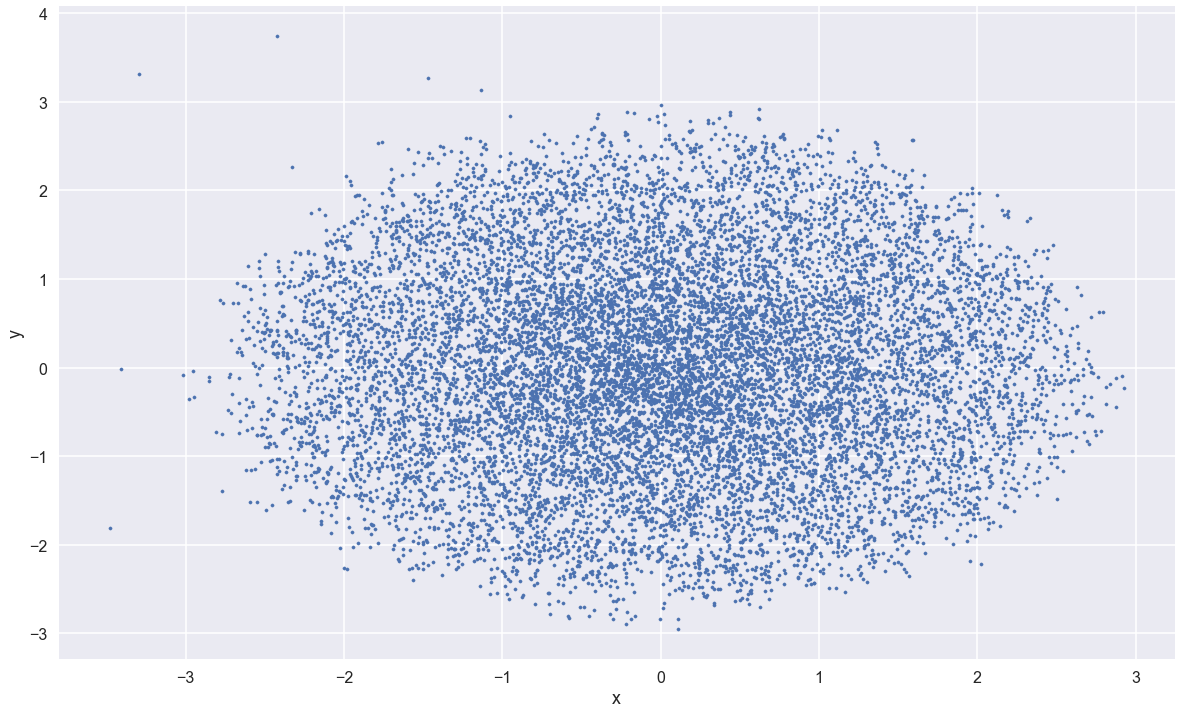

In [24]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [25]:
# define a function for zooming into certain areas of the plot
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    

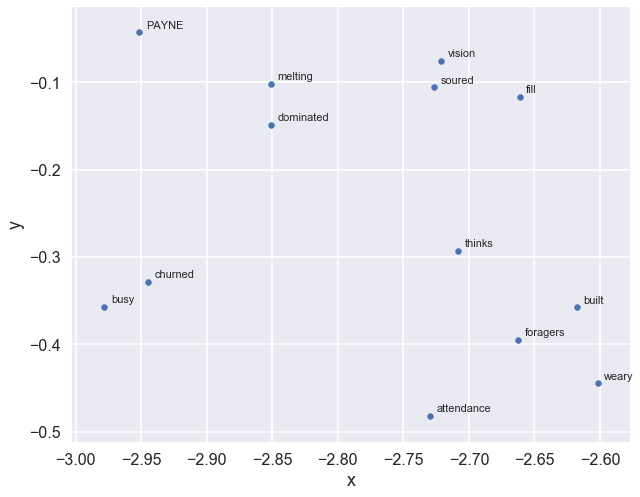

In [26]:
# now the hunt for interesting stuff, lets try his first
plot_region(x_bounds=(-3.0, -2.6), y_bounds=(-0.5, 0.0))

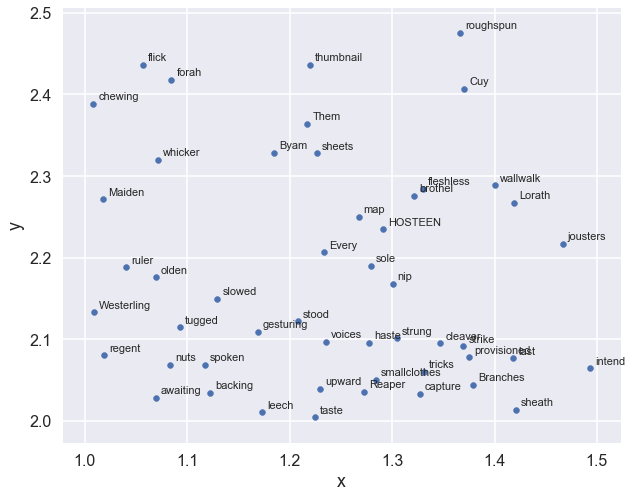

In [27]:
# now the hunt for interesting stuff, lets try his first
plot_region(x_bounds=(1, 1.5), y_bounds=(2, 2.5))

In [28]:
thrones2vec.wv['sword'].shape
type(thrones2vec.wv['sword'])
print(thrones2vec.wv['sword'])
print(thrones2vec.wv['dagger'])


[ -2.66678748e-04   2.96592771e-04   1.19158556e-03  -1.03158806e-03
  -5.91507880e-04   3.63857434e-05   1.66231254e-03  -4.06619045e-04
  -2.59382883e-04  -6.36265439e-04   4.04762570e-04   9.34436452e-04
  -2.92924873e-04  -1.26601837e-04   1.01364303e-05   1.03556353e-03
   8.39752844e-04   1.65181479e-03  -2.20332309e-04   9.47226072e-04
  -2.48271943e-04   1.26112858e-03  -1.21017940e-04   1.09870125e-04
  -3.22591193e-04   1.53717771e-03   1.08661084e-03   2.46234471e-04
   1.74294735e-04  -1.44971884e-03  -8.54843296e-04  -1.41245604e-03
  -1.06884225e-03   5.08788333e-04  -1.52922957e-03  -1.33049523e-03
   7.87469617e-04  -4.43952013e-04   1.04775291e-03   1.38534117e-03
   1.05534040e-03   1.00058247e-03  -5.58107742e-04   1.30836712e-03
   1.18501647e-03   9.28738082e-05  -1.07605287e-04  -1.06003019e-04
   9.22486011e-04   6.45098800e-04   9.10273520e-04   4.55288420e-04
  -1.40467624e-03   8.47448828e-04   4.89501865e-04  -1.01521844e-03
   1.44547538e-03  -1.40162208e-03

In [29]:
print(thrones2vec.wv)
print(dir(thrones2vec.wv))

['__class__', '__contains__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__getitem__', '__hash__', '__ignoreds', '__init__', '__module__', '__new__', '__numpys', '__recursive_saveloads', '__reduce__', '__reduce_ex__', '__repr__', '__scipys', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_save_specials', '_smart_save', 'accuracy', 'doesnt_match', 'evaluate_word_pairs', 'index2word', 'init_sims', 'load', 'load_word2vec_format', 'log_accuracy', 'log_evaluate_word_pairs', 'most_similar', 'most_similar_cosmul', 'n_similarity', 'save', 'save_word2vec_format', 'similar_by_vector', 'similar_by_word', 'similarity', 'syn0', 'syn0norm', 'vector_size', 'vocab', 'wmdistance', 'word_vec']


# BOOM figured it out
Ok, so instead of **thrones2vec.syn0** we need to do **thrones2vec.wv.syn0** because it is this ".wv" attribute of the w2v model that contains the keyedvalues or whatever. (the 300d matrix)

## RTFM - read the fucking manual
https://radimrehurek.com/gensim/models/word2vec.html
https://radimrehurek.com/gensim/apiref.html

Ah I see, once we reach a point of "no more updates, only querying," then we should switch to the gensim.models.KeyedVectors instance in wv. Check the object I printed above, its basically just the model with ".wv" after it.



In [30]:
# so delete the model, but save the ".wv" keyedvector from it
word_vectors = thrones2vec.wv
del(thrones2vec)

In [32]:
word_vectors # sweet


In [33]:
help(word_vectors)

Help on KeyedVectors in module gensim.models.keyedvectors object:

class KeyedVectors(gensim.utils.SaveLoad)
 |  Class to contain vectors and vocab for the Word2Vec training class and other w2v methods not directly
 |  involved in training such as most_similar()
 |  
 |  Method resolution order:
 |      KeyedVectors
 |      gensim.utils.SaveLoad
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, word)
 |  
 |  __getitem__(self, words)
 |      Accept a single word or a list of words as input.
 |      
 |      If a single word: returns the word's representations in vector space, as
 |      a 1D numpy array.
 |      
 |      Multiple words: return the words' representations in vector space, as a
 |      2d numpy array: #words x #vector_size. Matrix rows are in the same order
 |      as in input.
 |      
 |      Example::
 |      
 |        >>> trained_model['office']
 |        array([ -1.40128313e-02, ...])
 |      
 |        >>> trained_model[['office'

# Conclusion

Alright, this tutorial is losing me. It was used on an older version of gensim that I can't seem to figure out how to get into a 2D matrix from a 300D Array.

(I think this means this is a array of 300 matrices)

I am going to do some additional gensim-specific tutorials that are a bit less scatter-brained. 

I don't want to backtrack into an older version, I'd rather learn how this version works.

This tutorial started off great and then really train-wrecked.